In [1]:
# Import everything from slmcontrol
from slmcontrol import *
from cameras.ImagingSource import ImagingSourceCamera
import matplotlib.pyplot as plt
from partially_coherent_sources import generate_masks
from tqdm import trange
import h5py

# Initialize our slm display
slm = SLMdisplay(monitor=1)

# Constructs a grid that is defined by the size and resolution of the SLM
x, y = build_grid(15.36, 8.64, 1920, 1080)

In [2]:
# The input beam, which we assme to be a gaussian
incoming = hg(x, y, 0, 0, 2.4)

# The beam that we wish to produce. 
# In this case, a Laguerre-Gaussian with p=0 and l=1
desired = lg(x, y, 0, 0, .2)

# Generates the hologram that will be shown in the SLM
holo = generate_hologram(desired, incoming, x, y, 96, 3, -4, 0, 0)

# Displays the generated hologram
slm.updateArray(holo)

In [10]:
from juliacall import Main as jl
jl.include("test.jl")

_x = jl.vec(jl.Array(x))
_y = jl.vec(jl.Array(y))
basis = jl.get_basis(_x,_y,2,.2)

In [9]:
n_masks = 300
masks = generate_masks(n_masks, weights, fields, method='phase_randomized')

In [5]:
camera = ImagingSourceCamera()

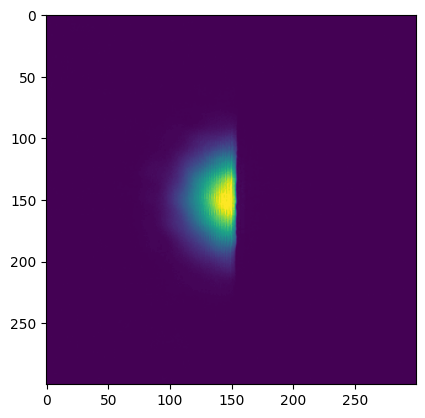

In [11]:
roi = (626,926,175,475)
plt.imshow(camera.capture(roi))

In [7]:
with h5py.File("data.h5","w-") as file:
    file["calibration"] = camera.capture(roi)

In [12]:
n_masks = 150
n_modes = 100
rhos = jl.sample(jl.GinibreEnsamble(2),n_modes)
images = np.empty((n_modes,roi[1]-roi[0],roi[3]-roi[2]))

for m in trange(n_modes):
    fields, weights = jl.get_fields_and_probs(rhos[:,:,m], basis)
    masks = generate_masks(n_masks, weights, fields, method='phase_randomized')

    holo = generate_hologram(masks[0], incoming, x, y, 96, 3, -4, 0, 0)
    for n in trange(n_masks-1):
        slm.updateArray(holo,sleep=0)
        holo = generate_hologram(masks[n+1], incoming, x, y, 96, 3, -4, 0, 0)
        images[m] += camera.capture(roi)
    slm.updateArray(holo)
    images[m] += camera.capture(roi)

with h5py.File("data.h5","w-") as file:
    file["images"] = images
    file["labels"] = rhos

100%|██████████| 100/100 [1:03:42<00:00, 38.22s/it]


FileExistsError: [Errno 17] Unable to synchronously create file (unable to open file: name = 'data.h5', errno = 17, error message = 'File exists', flags = 15, o_flags = 502)

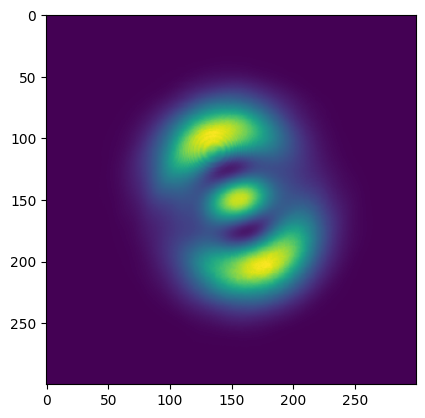

In [95]:
plt.imshow(images.mean(axis=0))

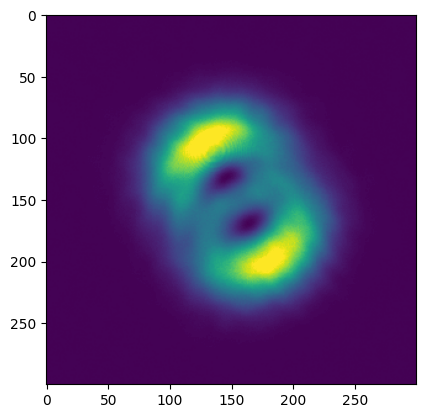

In [94]:
plt.imshow(images[1,:,:])

In [96]:
camera.close()